In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# HSMMの性能比較の数値実験

In [2]:
from IPython.core.display import display, Markdown, Latex
import math
import numpy as np
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, cauchy, laplace, gumbel_r, gamma, skewnorm, pareto, multivariate_normal
from typing import Callable

In [3]:
from sklearn.mixture import BayesianGaussianMixture

In [4]:
import sys
sys.path.append("../lib")
from learning.MixtureModel import HyperbolicSecantMixtureVB
from learning.MixtureModel import GaussianMixtureModelVB
from util.elementary_function import GaussianMixtureModel

# 問題設定

## 真の分布の設定
+ データ生成分布は変更しますが、混合比, 中心, scaleは同じものを流用

In [5]:
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = 0
true_s = np.array([[1.5, 1.5], [0.5, 0.5], [1, 1]])
true_b = np.array([[2, 4], [-4, -2], [0, 0]])
true_param = dict()
true_param["ratio"] = true_ratio
true_param["mean"] = true_b
true_param["precision"] = true_s
true_param["scale"] = np.array([np.diag(1/np.sqrt(true_s[k,:])) for k in range(len(true_ratio))])
K0 = len(true_ratio)
M = true_b.shape[1]

## Learning setting:

In [11]:
### 学習データの数
n = 400

### テストデータの数
N = 10000

### データの出方の個数
ndataset = 10

### 事前分布のハイパーパラメータ
pri_params = {
    "pri_alpha": 0.1,
    "pri_beta": 0.001,
    "pri_gamma": M+2,
    "pri_delta": 1
}

### データ生成の回数
data_seed_start = 201907
data_seeds = np.arange(start = data_seed_start, stop = data_seed_start + ndataset, step = 1)

### 学習モデルの初期値の乱数 -> データseedにoffsetを加えたものを使う
learning_num = 10
learning_seed_offset = 100

### 繰り返しアルゴリズムの繰り返し回数
learning_iteration = 1000

### 学習モデルのコンポーネントの数
K = np.array([3, 5])

# 性能評価
+ 1連の流れ
    1. データ生成する
    1. 学習を行う
    1. 精度評価を行う
    1. 1に戻って再度計算

# コンポーネントの分布が正規分布の場合

In [23]:
gerror_gmm.mean()

0.02514180408429529

In [24]:
gerror_hsmm.mean()

0.048536554645436256

In [21]:
gerror_gmm = np.zeros(len(data_seeds))
gerror_hsmm = np.zeros(len(data_seeds))
for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = GaussianMixtureModel().rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = GaussianMixtureModel().rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    gmm_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    true_empirical_entropy = GaussianMixtureModel().logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm[i] = (true_empirical_entropy - gmm_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)

903.981429516437
903.9814258786723
903.9814281376198
903.9814324362619
903.9814243648941
903.9814265684445
903.981422071159
903.9814303637204
903.981426580004
903.9814260070493
169.7996929533939
169.79969252397478
169.79969250324143
169.7996927306208
169.79969236717153
169.7996935318912
169.7996929630192
169.79969117290904
169.79969236072054
169.79969239595675
871.5297778595997
871.5297781848127
871.5297787794649
871.5297779481608
871.5297776856546
871.5297781645987
871.5297785038308
871.5297810126108
871.5297779189192
871.5297774274628
150.0610669224758
150.06107488010997
150.06107353465228
150.06106869304995
150.0610671365531
150.0610676509932
150.06106963472075
150.06107059868026
150.06106901829196
150.06106948484455
885.1972054939513
885.1972088685828
885.1972075614395
885.1972056657614
885.1972055321526
885.1972058812671
885.197206047738
885.1972048932628
885.1972063375912
885.1972055320941
158.196597203985
158.19659709210805
158.19659728089903
158.19659726244652
158.196597563125


In [8]:


gmm_obj.fit(train_X)

891.0764684639321
891.0764602682958
891.0764866216606
891.0764826361553
891.0764892949285


In [60]:
(GaussianMixtureModel().logpdf(test_X, true_ratio, true_b, true_s) - gmm_obj.predict_logproba(test_X))/N

0.02437652610062796

In [65]:
hsmm_obj = HyperbolicSecantMixtureVB(iteration = 1000, step=2)

hsmm_obj.fit(train_X)

215.33659546075836
215.33659711340323
215.33659884373162
215.33659457223905
215.33659817248923


HyperbolicSecantMixtureVB(K=3, iteration=1000, learning_seed=-1, pri_alpha=0.1,
                          pri_beta=0.001, pri_delta=2, pri_gamma=2,
                          restart_num=5, step=2, tol=1e-05)

In [67]:
hsmm_obj._result

{'ratio': array([0.33642493, 0.35290046, 0.31067461]),
 'mean': array([[ 0.06221552, -0.13512344],
        [ 1.91053983,  4.14906158],
        [-4.05100871, -2.09342019]]),
 'precision': array([[6.52674772, 6.00226438],
        [8.82705598, 9.60987196],
        [3.42154027, 3.53654596]]),
 'scale': array([[[0.15321567, 0.        ],
         [0.        , 0.16660379]],
 
        [[0.11328805, 0.        ],
         [0.        , 0.10405966]],
 
        [[0.29226603, 0.        ],
         [0.        , 0.28276177]]]),
 'alpha': array([134.67089895, 141.26605459, 124.36304647]),
 'beta': array([[25.99235773, 25.82612603],
        [27.57578457, 27.77076546],
        [23.27811503, 23.12094903]]),
 'mu': array([[ 0.06221552, -0.13512344],
        [ 1.91053983,  4.14906158],
        [-4.05100871, -2.09342019]]),
 'gamma': array([[69.28544947, 69.28544947],
        [72.58302729, 72.58302729],
        [64.13152323, 64.13152323]]),
 'delta': array([[10.61561629, 11.54321855],
        [ 8.22278996,  

In [66]:
(GaussianMixtureModel().logpdf(test_X, true_ratio, true_b, true_s) - hsmm_obj.predict_logproba(test_X))/N

0.06657115960186492

In [6]:
a = 0
if a == 0: print("aa")

aa


In [13]:
true_train_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_train_label_arg = np.argmax(true_train_label, axis = 1)
# true_test_label = np.random.multinomial(n = 1, pvals = true_ratio, size = test_data_num)
# true_test_label_arg = np.argmax(true_test_label, axis = 1)

In [56]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = t.rvs(df = 3, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = t.rvs(df = 1.5, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

# HSMMの数値実験
1. 比較対象:
    + HSMM, GMM(diag), GMM(cov)
2. 評価方法:
    + データの出方を変えて、平均汎化誤差, クラスタ一致の平均0-1損失, クラスタの平均KL,
        + クラスタKL $KL(q(y^n|x^n) || p(y^n|x^n)) = \sum_{(y^n)^{(l)} \in Cluster} \log \frac{q((y^n)^{(l)},|(x^n)^{(l)})}{p((y^n)^{(l)},|(x^n)^{(l)})},$
        + 学習に用いる乱数の種はそれぞれの推定で共有 -> 推定の初期値は同じで計算する
        + 真の分布の変更に対して同じラベルを用いて推定と評価を行う
        + 真の分布について
            + データの事件は2, コンポーネントの数は3, 混合比は等分割, 平均は(4,4), (-4,-4), (0,0), scaleは(1.5, 1.5), (0.5, 0.5), (1,1)
        + **その他の実験設定は後程記述**
3. 真の分布:混合分布で以下の分布の混合
    1. 正規分布
    2. 双曲正割分布
    3. ラプラス分布
    4. t-分布
    5. 他にうまく行く分布
4. 実験の詳細設定
    1. 学習データの個数: 400個
    2 データの出方を変える回数: 10回
    3. 1回の学習の繰り返し回数: 1000回
    4. 1回の学習の初期値を変える回数: 10回
    5. 学習モデルのコンポーネントの数: trueと同じ場合, trueより2大きい場合
    6. ハイパーパラメータ$ \eta = (\alpha, \beta, \nu, \sigma)$: $\eta = (\alpha, \beta, \nu, \sigma) = (0.1, 0.001, M+2, I_M)$
    7. 汎化誤差の近似に用いるテストデータの数: 10000個

### Suplementary material: Local Variational Approximation algorithm for HSMM
+ Model:
    + $p(x|w) = \sum_{k=1}^K a_k \prod_{j = 1}^M \frac{\sqrt{s_{kj}}}{2\pi} \frac{1}{\cosh(\frac{s_{kj}}{2}(x_j - b_{kj}))}$
    + $x, b_k \in \mathbb{R}^M, s_k \in \mathbb{R}_+^M$
+ Prior distribution:
    + $\varphi(w) = Dir(a|\{ \alpha_k \}_{k=1}^K) \prod_{k=1}^K N(b_k|0, (s_k \beta_k)^{-1} ) Gam(s_k|\gamma_k, \delta_k)$
+ Algorithm
   1. Initializing the following values:
       + $g_{ikj}(\eta), v_{ikj}(\eta), h_{ik}(\xi), u_{ik}(\xi)$
   2. Update the following values
       + $\hat{\alpha}_k = \alpha_k + \sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\beta}_{kj} = \beta_k + \sum_{i=1}^n -2v_{ikj}(\eta)$
       + $\hat{m}_{kj} = \frac{1}{\hat{\beta}_k} \sum_{i=1}^n -2v_{ik}(\eta)x_i$
       + $\hat{\gamma}_{kj} = \gamma_k + \frac{1}{2}\sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\delta}_{kj} = \delta_k + \sum_{i=1}^n -v_{ikj}(\eta)x_{ij}^2 - \frac{\hat{\beta}_{kj}}{2}\hat{m}_{kj}^2$
   3. Update the following values
       + $g_{ikj}(\eta) = \frac{\hat{\gamma}_{kj}}{\hat{\delta}_{kj}} (x_{ij} - \hat{m}_{kj})^2 + \frac{1}{\hat{\beta}_{kj}}$
       + $v_{ikj}(\eta) = -u_{ik}(\xi)\frac{ \tanh(\sqrt{g_{ikj}(\eta)}/2) }{4\sqrt{g_{ikj}(\eta)}}$
   4. Update the following values
       + $h_{ik}(\xi) = \psi(\hat{\alpha}_k) - \psi(\sum_{l=1}^K \hat{\alpha}_l) + \frac{1}{2} \sum_{j=1}^M (\psi(\hat{\gamma}_{kj}) - \log(\hat{\delta}_{kj})) - \sum_{j=1}^M \log(\cosh(\sqrt{g_{ikj}(\eta)}/2)) $
       + $u_{ik}(\xi) = \frac{ \exp(h_{ik}(\xi)) }{ \sum_{l=1}^K \exp(h_{il}(\xi)) }$
       + where,$\psi(x) = \frac{d}{dx}\log \Gamma(x)$
   5. Return back to 2.
   
+ Evaluation function $\overline{F}_{\xi, \eta}(x^n)$:
    + $\overline{F}_{\xi, \eta}(x^n) = - \phi(h(\xi)) - \psi(g(\eta)) + u(\xi) \cdot h(\xi) + v(\eta) \cdot g(\eta) $  
        $+ nM \log 2 \pi + \log \Gamma(\sum_{l = 1}^K \hat{\alpha}_l) - \log \Gamma({\sum_{l = 1}^K\alpha}_l) + \sum_{k=1}^K \log \frac{\Gamma(\alpha_k)}{\Gamma(\hat{\alpha}_k)}$  
        $+ \sum_{k=1}^K \sum_{j=1}^M \bigl\{ \frac{1}{2} \log \frac{\hat{\beta}_{kj}}{\beta_{kj}} + \hat{\gamma}_{kj} \log \hat{\delta}_{kj} - \gamma_{kj} \log \delta_{kj} - \log \Gamma(\hat{\gamma}_{kj}) + \log \Gamma(\gamma_{kj}) \bigr\}$

## Used funtions

In [8]:
def printmd(x):
    display(Markdown(x))

In [9]:
def random_hsm(n, loc = 0, scale = 1):
    """
    Generate data following hyperbolic secant distribution.
    Let $Y \sim standard_cauchy(x)$,  
    random variable $X = \frac{2}{\sqrt{s}}\sinh^{-1}(Y) + b$ follows to  
    $X \sim p(x) = \frac{\sqrt{s}}{2\pi}\frac{1}{\cosh(s(x-b)/2)}$.
    """
    Y = np.random.standard_cauchy(size=n)
    X = 2/np.sqrt(scale)*np.arcsinh(Y) + loc    
    return X

In [10]:
def logpdf_hypsecant(x:np.ndarray, mean:np.ndarray, precision:np.ndarray):
    """
    Calculate \log p(x|w) = \sum_{j=1}^M \log(\frac{\sqrt{s_j}}{2\pi} 1/cosh(\sqrt{s_j}/2(x_j - b_j)))
    Input:
     + x: n*M
     + mean: M
     + precision :M*M
    Output:
     + n*M
    """
    (n, M) = x.shape
    expand_precision = np.repeat(np.diag(precision), n).reshape(M,n).T
    y = np.sqrt(expand_precision)*(x - np.repeat(mean, n).reshape(M,n).T)/2
    return(np.log(expand_precision)/2 - np.log(2*np.pi) - logcosh(y)).sum(axis = 1)

def logpdf_multivariate_normal(x:np.ndarray, mean:np.ndarray, cov:np.ndarray):
    """
    Calculate \log p(x|w) = \sum_{j=1}^M \log(\frac{\sqrt{s_j}}{2\pi} 1/cosh(\sqrt{s_j}/2(x_j - b_j)))
    Input:
     + x: n*M
     + mean: M
     + cov :M * M
    Output:
     + n*M
    """
    return(multivariate_normal.logpdf(x, mean = mean, cov = cov))

In [11]:
def logcosh(x:np.ndarray):
    """
    対数双曲線関数の計算
    + 普通にライブラリを呼ぶと、オーバーフローするのでその対策
    """
    return np.abs(x) + np.log((1 + np.exp(-2 * np.abs(x)))/2)
    
#     ret_val = -x + np.log((1 + np.exp(2*x))/2)
#     (row, col) = np.where(x > 0)
#     ret_val[row, col] = x[row, col] + np.log((1 + np.exp(-2*x[row,col]))/2)
#     return ret_val

def logpdf_mixture_dist(x:np.ndarray, param:dict, component_log_dist:Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]):
    """
    対数尤度の計算
    確率分布が混合分布の時を想定:
    $\log p(x|w) = \sum_{i = 1}^n \log p(x_i|w) = \sum_{i = 1}^n \log \exp(L_{ik}(w)) =  \sum_{i = 1}^n \{\hat{L}_{i} + \log \exp(L_{ik}(w) - \hat{L}(i)) \}$,
    where L_{ik} = \log a_k + \log p(x_i|w, y_{ik} = 1)\hat{L}(i) = \max_{k} L_{ik}, p(x_i|w, y_{ik}=1):i番目のサンプルのk番目のクラスタの確率分布    
    
    + 入力:
        1. x:入力データ(n*M)
        2. param: 確率分布のパラメータ(ratio: 混合比, mean: 各クラスタの平均値 K*M, scale: 各クラスタのscale(正規分布における標準偏差) K*M)
        3. component_log_dist: 各クラスタの対数確率密度の値 logp(x|w,y)    
    """
    n = x.shape[0]
    K = len(param["ratio"])
    loglik = np.zeros((n,K))
    for k in range(K):
        if param["scale"].ndim == 2:
            loglik[:,k] = np.log(param["ratio"][k]) + component_log_dist(test_x, param["mean"][k,:],  param["scale"][k,:])
        elif param["scale"].ndim == 3:
            loglik[:,k] = np.log(param["ratio"][k]) + component_log_dist(test_x, param["mean"][k,:],  param["scale"][k,:,:])
        else:
            raise ValueError("Error precision, dimension of precision must be 2 or 3!")
    max_loglik = loglik.max(axis = 1)
    norm_loglik = loglik - np.repeat(max_loglik,K).reshape(n,K)
    return (np.log(np.exp(norm_loglik).sum(axis = 1)) + max_loglik)

In [12]:
from sklearn.mixture import BayesianGaussianMixture
def fit_gmm_sklearn(train_X:np.ndarray, K:int,
                    pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                    iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    """
    Estimating GMM by sklearn library.
    
    + Input:
        + train_X: input data
        + pri_alpha: hyperparameter for prior distribution of symmetric Dirichlet distribution.
        + pri_beta: hyperparameter for prior distribution of Normal distribution for inverse variance.
        + pri_gamma: hyperparameter for prior distribution of Gamma distribution for shape parameter.
        + pri_delta: hyperparameter for prior distribution of Gamma distribution for rate parameter.
        + iteration: Number of iteration.
        + restart_num: Number of restart of inital values.
        + learning_seeds: Seeds for initial values.
        
    + Output:
        + Dictionary of the best estimated result:
            1. alpha: parameter for posterior distribution of Dirichlet distribution.
            2. mu: parameter for posterior distribution of Normal distribution for mean parameter.
            3. beta: parameter for posterior distribution of Normal distribution for inverse variance parameter.
            4. gamma: parameter for posterior distribution of Gamma distribution for shape parameter.
            5. delta: parameter for posterior distribution of Gamma distribution for rate parameter.
            6. h_xi: Value of E_w[log p(x_i, z_i = k|w)], where z_i is latent variable. This parameters form posterior latent distribution.
            7. u_xi: Value of p(z_i = k). This parameters represent posterior probability of latent variable
            8. energy: Value of the best evaluation function.
            9. seed: Value of the best learning seed.
    """
    M = train_X.shape[1]
    sklearn_gmm_obj = BayesianGaussianMixture(n_components=K,
                                              covariance_type="full",
                                              max_iter=iteration,
                                              mean_precision_prior = pri_beta,
                                              degrees_of_freedom_prior = M*pri_gamma,
                                              covariance_prior = pri_delta * np.eye(M),
                                              weight_concentration_prior_type="dirichlet_distribution",
                                              weight_concentration_prior=pri_alpha,
                                              n_init=5)
    sklearn_gmm_obj.fit(train_X)
        
    result = dict()
    result["ratio"] = sklearn_gmm_obj.weights_
    result["mean"] = sklearn_gmm_obj.means_
    result["precision"] = sklearn_gmm_obj.precisions_
    result["scale"] = sklearn_gmm_obj.covariances_
    result["u_xi"] = sklearn_gmm_obj.predict_proba(train_X)
    
    return result

In [13]:
def fit_lva_gmm(train_X:np.ndarray, K:int,
                 pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                 iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    """
    LVA for GMM.
    This is same with Variational Bayes inference for GMM.
    Since the algorithm fails to local minima, the best estimator are chosen in several initial values.
    
    + Input:
        + train_X: input data
        + pri_alpha: hyperparameter for prior distribution of symmetric Dirichlet distribution.
        + pri_beta: hyperparameter for prior distribution of Normal distribution for inverse variance.
        + pri_gamma: hyperparameter for prior distribution of Gamma distribution for shape parameter.
        + pri_delta: hyperparameter for prior distribution of Gamma distribution for rate parameter.
        + iteration: Number of iteration.
        + restart_num: Number of restart of inital values.
        + learning_seeds: Seeds for initial values.
        
    + Output:
        + Dictionary of the best estimated result:
            1. alpha: parameter for posterior distribution of Dirichlet distribution.
            2. mu: parameter for posterior distribution of Normal distribution for mean parameter.
            3. beta: parameter for posterior distribution of Normal distribution for inverse variance parameter.
            4. gamma: parameter for posterior distribution of Gamma distribution for shape parameter.
            5. delta: parameter for posterior distribution of Gamma distribution for rate parameter.
            6. h_xi: Value of E_w[log p(x_i, z_i = k|w)], where z_i is latent variable. This parameters form posterior latent distribution.
            7. u_xi: Value of p(z_i = k). This parameters represent posterior probability of latent variable
            8. energy: Value of the best evaluation function.
            9. seed: Value of the best learning seed.
    """
    
    (n, M) = train_X.shape
    ### Setting for static variable in the algorithm.
    expand_x = np.repeat(train_X, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension

    min_energy = np.inf
    result = dict()
    
    for restart in range(restart_num):
        ### Set learning seed if learning_seeds is specified.
        if learning_seeds is not None and len(learning_seeds) >= restart:
            np.random.seed(learning_seeds[restart])

        energy = np.zeros(iteration)
        ### Setting for initial value
        est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)
    
        ### Start learning.
        for ite in range(iteration):
            ### Update posterior distribution of parameter.
            est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
            est_beta = np.repeat(pri_beta + est_u_xi.sum(axis = 0), M).reshape(K,M)
            est_m = est_u_xi.T @ train_X / est_beta
            est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
            est_delta = pri_delta + est_u_xi.T @ (train_X**2) /2 - est_beta / 2 * est_m**2
            
            ### Update posterior distribution of latent variable
            est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))
            est_h_xi = -M/2*np.log(2*np.pi) + np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - est_g_eta.sum(axis = 2)/2
            max_h_xi = est_h_xi.max(axis = 1)
            norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
            est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

            ### Calculate evaluation function
            energy[ite] = - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum()
            energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
            energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
        
        print(energy[-1])        
        if energy[-1] < min_energy:
            min_energy = energy[-1]
            result["ratio"] = est_alpha / est_alpha.sum()
            result["mean"] = est_m
            result["precision"] = est_gamma / est_delta
            result["scale"] = np.array([np.diag(est_delta[k,:] / est_gamma[k,:]) for k in range(K)])
            result["alpha"] = est_alpha
            result["mu"] = est_m
            result["beta"] = est_beta
            result["gamma"] = est_gamma
            result["delta"] = est_delta
            result["h_xi"] = est_h_xi
            result["u_xi"] = est_u_xi
            result["energy"] = energy
            if learning_seeds is not None and len(learning_seeds) >= restart:
                result["seed"] = learning_seeds[restart]
    return result

In [14]:
def fit_lva_hsmm(train_X:np.ndarray, K:int,
                 pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                 iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    """
    LVA for HSMM.
    The algorithm is described in the above cell.
    Since the algorithm fails to local minima, the best estimator are chosen in several initial values.
    
    + Input:
        + train_X: input data
        + pri_alpha: hyperparameter for prior distribution of symmetric Dirichlet distribution.
        + pri_beta: hyperparameter for prior distribution of Normal distribution for inverse variance.
        + pri_gamma: hyperparameter for prior distribution of Gamma distribution for shape parameter.
        + pri_delta: hyperparameter for prior distribution of Gamma distribution for rate parameter.
        + iteration: Number of iteration.
        + restart_num: Number of restart of inital values.
        + learning_seeds: Seeds for initial values.
        
    + Output:
        + Dictionary of the best estimated result:
            1. alpha: parameter for posterior distribution of Dirichlet distribution.
            2. mu: parameter for posterior distribution of Normal distribution for mean parameter.
            3. beta: parameter for posterior distribution of Normal distribution for inverse variance parameter.
            4. gamma: parameter for posterior distribution of Gamma distribution for shape parameter.
            5. delta: parameter for posterior distribution of Gamma distribution for rate parameter.
            6. h_xi: Value of E_w[log p(x_i, z_i = k|w)], where z_i is latent variable. This parameters form posterior latent distribution.
            7. u_xi: Value of p(z_i = k). This parameters represent posterior probability of latent variable.
            8. g_eta: Value of auxiliary variable, which represents g(\eta) in the algorithm.
            9. v_eta: Value of auxiliary variable, which represents v(\eta) in the algorithm.
            10. energy: Value of the best evaluation function.
            11. seed: Value of the best learning seed.
    """    
    
    (n, M) = train_X.shape
    ### Setting for static variable in the algorithm.
    expand_x = np.repeat(train_X, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension

    min_energy = np.inf
    result = dict()
    
    for restart in range(restart_num):
        ### Set learning seed if learning_seeds is specified.
        if learning_seeds is not None and len(learning_seeds) >= restart:
            np.random.seed(learning_seeds[restart])

        energy = np.zeros(iteration)
        ### Setting for initial value
        est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)

        est_g_eta = np.abs(np.random.normal(size=(n,K,M)))
        est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

        ### Start learning.
        for ite in range(iteration):
            ### Update posterior distribution of parameter
            est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
            est_beta = pri_beta + (-2*est_v_eta.sum(axis = 0))
            est_m = -2 * (expand_x * est_v_eta).sum(axis = 0) / est_beta
            est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
            est_delta = pri_delta - (expand_x**2 * est_v_eta).sum(axis = 0) - est_beta / 2 * est_m**2
            
            ### Update auxiliary variables
            est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))
            est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

            ### Update posterior distribution of latent variable
            sqrt_g_eta = np.sqrt(est_g_eta)
            est_h_xi = np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - (sqrt_g_eta/2 +  np.log( (1 + np.exp(-2*sqrt_g_eta/2 ))/2)).sum(axis = 2)
            max_h_xi = est_h_xi.max(axis = 1)
            norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
            est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

            ### Calculate evaluation function
            energy[ite] = (np.repeat(est_u_xi, M).reshape(n, K, M) * (sqrt_g_eta/2 +  np.log( (1 + np.exp(-2*sqrt_g_eta/2 ))/2)) ).sum() - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum() + (est_v_eta * est_g_eta).sum()
            energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
            energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
        
        print(energy[-1])        
        if energy[-1] < min_energy:
            min_energy = energy[-1]
            result["ratio"] = est_alpha / est_alpha.sum()
            result["mean"] = est_m
            result["precision"] = est_gamma / est_delta
            result["scale"] = np.array([np.diag(est_delta[k,:] / est_gamma[k,:]) for k in range(K)])
            result["alpha"] = est_alpha
            result["beta"] = est_beta
            result["mu"] = est_m
            result["gamma"] = est_gamma
            result["delta"] = est_delta
            result["h_xi"] = est_h_xi
            result["u_xi"] = est_u_xi
            result["g_eta"] = est_g_eta
            result["v_eta"] = est_v_eta            
            result["energy"] = energy
            if learning_seeds is not None and len(learning_seeds) >= restart:
                result["seed"] = learning_seeds[restart]
    return result

In [15]:
import itertools
def evaluate_correct_cluster_number(result:dict, noise_data_num:int, true_label_arg, K:int, predict_label = None) -> (float, np.ndarray, np.ndarray):
    """
    0-1損失によるクラスタ分布の評価
    1つのデータセットに対する評価で、ラベルの一致数の最大値の平均値を計算する
    + 入力:
        1. result: dict, u_xiをキーに持つ必要がある
        2. noise_data_num: 外れ値データの数
        3. true_label_arg: 真のラベル番号
        4. predict_label: 予測されたラベル番号
    + 出力:
        1. max_correct_num: ラベルの最大一致数
        2. max_perm: 最大一致数を与える置換
        3. max_est_label_arg: 最大の一致数を与えるラベルの番号
    
    """
    
    if predict_label is not None:
        est_label_arg = predict_label
    else:        
        est_label_prob = result["u_xi"]
        target_label_arg = true_label_arg
        est_label_arg = np.argmax(est_label_prob, axis = 1)

    if noise_data_num > 0:
        target_label_arg = true_label_arg[:-noise_data_num]
        est_label_arg = est_label_arg[:-noise_data_num]
    else:
        target_label_arg = true_label_arg
        
    max_correct_num = 0
    for perm in list(itertools.permutations(range(K), K)):
        permed_est_label_arg = est_label_arg.copy()
        for i in range(len(perm)):
            permed_est_label_arg[est_label_arg == i] = perm[i]
        correct_num = (permed_est_label_arg == target_label_arg).sum()
        if correct_num > max_correct_num:
            max_correct_num = correct_num
            max_perm = perm
            max_est_label_arg = permed_est_label_arg
    return (max_correct_num, max_perm, max_est_label_arg)

In [16]:
def evaluate_log_loss(fit_result:dict, true_param:dict, noise_data_num:int, test_x:np.ndarray,
                      true_logpdf:Callable[[np.ndarray, dict],np.ndarray], pred_logpdf:Callable[[np.ndarray, dict], np.ndarray]):
    """
    汎化誤差の計算を行う
    HSMMについては予測分布の計算が面倒なので、とりあえず平均プラグインでそれぞれの分布の性能比較を行う。
    + 汎化誤差G(x^n,y^n):
        + G(x^n) = \int q(x) \log q(x) / p(x|x^n) dx \arrox \sum_{l = 1}^N \log q(x^l) / p(x^l|x^n), x_l ~ q(x_l),
        + where p(x|x^n) = \int p(x|w) p(w|x^n) dw \approx p(x|E[w])
    + 入力
        1. fit_result: dict, ratio, mean, scaleをキーに持つ必要がある
        2. true_param: dict: ratio, mean, scaleをキーに持つ必要がある
        3. noise_data_num: データに含まれる外れ値の数
        4. test_x: x_jのデータ N*M行列
        5. true_logpdf: 真の分布の対数尤度関数
        6. pred_logpdf: 予測分布の対数尤度関数
    + 出力 汎化誤差の値
    """
    
    if noise_data_num > 0:
        return (true_logpdf(test_x, true_param) - pred_logpdf(test_x, fit_result))[:-noise_data_num].mean()
    else:
        return (true_logpdf(test_x, true_param) - pred_logpdf(test_x, fit_result)).mean()

In [17]:
from sklearn.mixture import BayesianGaussianMixture
def learning_and_labeling():
    """
    テストに用いたメイン関数
    やっていること:
    1. データ生成分布のプロット
    2. それぞれの分布による推定
    3. 0-1損失をそれぞれ計算
    4. 汎化誤差の計算
    5. それぞれの推定によって得られたラベルを用いて色付けした結果
    """
    
    printmd("### 1. Data distribution:")
    plot_scatter_with_label(train_x, true_train_label_arg,  K0, noise_data_num)
    
    printmd("### 2. Learning by sklearn.mixture.BayesianGaussianMixture:")
    sklearn_gmm_result = fit_gmm_sklearn(train_x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds = learning_seeds)
    print("mean plug-in parameters \n {0}".format({
        "est_ratio": sklearn_gmm_result["ratio"],
        "est_mean": sklearn_gmm_result["mean"],
        "est_precision": sklearn_gmm_result["precision"]
    }))
    (correct_num_skgmm, perm_skgmm, label_arg_skgmm) = evaluate_correct_cluster_number(sklearn_gmm_result, noise_data_num, true_train_label_arg, K)    
    
    printmd("### 3. Learning by GMM:")
    gmm_result = fit_lva_gmm(train_x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds = learning_seeds)
    print("mean plug-in parameters: \n {0}".format({
        "est_ratio": gmm_result["alpha"] / sum(gmm_result["alpha"]),
        "est_mean": gmm_result["mu"],
        "est_precision": gmm_result["gamma"] / gmm_result["delta"]
    }))
    (correct_num_gmm, perm_gmm, label_arg_gmm) = evaluate_correct_cluster_number(gmm_result, noise_data_num, true_train_label_arg, K)

    printmd("### 4. Learning by HSMM:")
    hsmm_result = fit_lva_hsmm(train_x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds=learning_seeds)
    print("mean plug-in parameters: \n {0}".format({
        "est_ratio": hsmm_result["alpha"] / sum(hsmm_result["alpha"]),
        "est_mean": hsmm_result["mu"],
        "est_precision": hsmm_result["gamma"] / hsmm_result["delta"]
    }))
    (correct_num_hsmm, perm_hsmm, label_arg_hsmm) = evaluate_correct_cluster_number(hsmm_result, noise_data_num, true_train_label_arg, K)

    printmd("### 5. Correct number of labeling of GMM by sklearn:")
    printmd("+ {0}/{1}".format(correct_num_skgmm, len(label_arg_hsmm)))
        
    printmd("### 5. Correct number of labeling of GMM:")
    printmd("+ {0}/{1}".format(correct_num_gmm, len(label_arg_hsmm)))

    printmd("### 6. Correct number of labeling of HSMM:")
    printmd("+ {0}/{1}".format(correct_num_hsmm, len(label_arg_hsmm)))

    printmd("### 7. Generalization error of GMM by sklearn:")
    printmd("+ {0}".format(evaluate_log_loss(sklearn_gmm_result, true_param, noise_data_num, test_x, true_logpdf, pred_logpdf_gmm)))
    
    printmd("### 8. Generalization error of GMM:")
    printmd("+ {0}".format(evaluate_log_loss(gmm_result, true_param, noise_data_num, test_x, true_logpdf, pred_logpdf_gmm)))
    
    printmd("### 9. Generalization error of HSMM:")
    printmd("+ {0}".format(evaluate_log_loss(hsmm_result, true_param, noise_data_num, test_x, true_logpdf, pred_logpdf_hsmm)))

    printmd("### 10. Data distribution labeled by GMM by sklearn:")
    plot_scatter_with_label(train_x, label_arg_skgmm,  K, noise_data_num)
    
    printmd("### 11. Data distribution labeled by GMM:")
    plot_scatter_with_label(train_x, label_arg_gmm,  K, noise_data_num)

    printmd("### 12. Data distribution labeled by HSMM:")
    plot_scatter_with_label(train_x, label_arg_hsmm,  K, noise_data_num)

In [18]:
def plot_scatter_with_label(x:np.ndarray, label_arg:np.ndarray,  K:int, noise_data_num):
    """
    Scatter plot for data x
    """
    for i in range(K):
        if noise_data_num > 0:
            plt.scatter(x[np.where(label_arg[:-noise_data_num] == i)[0],0], x[np.where(label_arg[:-noise_data_num] == i)[0],1])
        else:
            plt.scatter(x[np.where(label_arg == i)[0],0], x[np.where(label_arg == i)[0],1])        
    plt.show()

## Problem setting:

In [44]:
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = 0
true_s = np.array([[1.5, 1.5], [0.5, 0.5], [1, 1]])
true_b = np.array([[4, 4], [-4, -4], [0, 0]])
true_param = dict()
true_param["ratio"] = true_ratio
true_param["mean"] = true_b
true_param["precision"] = true_s
true_param["scale"] = np.array([np.diag(1/np.sqrt(true_s[k,:])) for k in range(len(true_ratio))])
K0 = len(true_ratio)
M = true_b.shape[1]

## Learning setting:

In [50]:
### 学習データの数
n = 400

### テストデータの数
N = 10000

### データの出方の個数
ndataset = 10

### 事前分布のハイパーパラメータ
pri_params = {
    "pri_alpha": 0.1,
    "pri_beta": 0.001,
    "pri_gamma": M+2,
    "pri_delta": 1
}

### データ生成の回数
data_seed_start = 201907
data_seeds = np.arange(start = data_seed_start, stop = data_seed_start + ndataset, step = 1)

### 学習モデルの初期値の乱数 -> データseedにoffsetを加えたものを使う
learning_num = 10
learning_seed_offset = np.arange(learning_num)+1

### 繰り返しアルゴリズムの繰り返し回数
learning_iteration = 1000

### 学習モデルのコンポーネントの数
K = np.array([3, 5])

### 予測分布の対数確率密度巻子の値を生成する関数
pred_logpdf_gmm = lambda x, param: logpdf_mixture_dist(x, param, logpdf_multivariate_normal)
pred_logpdf_hsmm = lambda x, param: logpdf_mixture_dist(x, param, logpdf_hypsecant)

## 実験設定で変更するパラメータを設定する
+ このパラメータをgrid計算して学習と評価を繰り返す

In [51]:
### 実験設定で変更するパラメータを設定する
experiment_params = {
    "learning_ncomponent": K,
    "learning_seed_offset": learning_seed_offset,
    "pri_params": [pri_params],
    "ndataset": [ndataset],
    "learning_iteration": [learning_iteration]
}

## 学習部分

In [22]:
from sklearn.model_selection import ParameterGrid

In [23]:
experiment_grids = ParameterGrid(experiment_params)

In [24]:
for data_seed in data_seeds:
    ### データ生成
    np.random.seed(data_seed)
    true_train_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
    true_train_label_arg = np.argmax(true_train_label, axis = 1)
    true_test_label = np.random.multinomial(n = 1, pvals = true_ratio, size = N)
    true_test_label_arg = np.argmax(true_test_label, axis = 1)
    
    for experiment_grid in experiment_grids:
        
        break

In [52]:
for a in ParameterGrid(experiment_params):
    print(a)
    break

{'learning_iteration': 1000, 'learning_ncomponent': 3, 'learning_seed_offset': 1, 'ndataset': 10, 'pri_params': {'pri_alpha': 0.1, 'pri_beta': 0.001, 'pri_gamma': 4, 'pri_delta': 1}}


In [60]:
for params, value in a["pri_params"].items():
    setattr(hsmm_obj, params, value)

In [65]:
a["pri_params"]

{'pri_alpha': 0.1, 'pri_beta': 0.001, 'pri_gamma': 4, 'pri_delta': 1}

In [64]:
hsmm_obj = HyperbolicSecantMixtureVB()
hsmm_obj.set_params(params = a["pri_params"])

> c:\users\user\git\lva\lib\learning\mixturemodel.py(242)set_params()
-> for params, value in params.items():


(Pdb)  params


{'params': {'pri_alpha': 0.1, 'pri_beta': 0.001, 'pri_gamma': 4, 'pri_delta': 1}}


(Pdb)  n


> c:\users\user\git\lva\lib\learning\mixturemodel.py(243)set_params()
-> setattr(self, params, value)


(Pdb)  params


'params'


(Pdb)  exit


BdbQuit: 

In [63]:
hsmm_obj

HyperbolicSecantMixtureVB(K=3, iteration=1000, learning_seed=-1, pri_alpha=0.1,
                          pri_beta=0.001, pri_delta=2, pri_gamma=2,
                          restart_num=5, step=20, tol=1e-05)

### Label setting for each data
+ Remark: Label is fixed through each cluster distribution.

In [25]:
true_train_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_train_label_arg = np.argmax(true_train_label, axis = 1)
true_test_label = np.random.multinomial(n = 1, pvals = true_ratio, size = test_data_num)
true_test_label_arg = np.argmax(true_test_label, axis = 1)

In [56]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = t.rvs(df = 3, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = t.rvs(df = 1.5, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

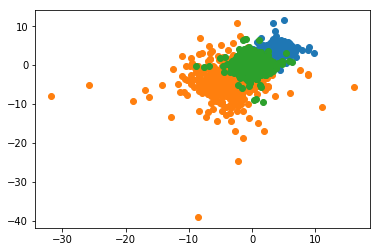

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([0.25343994, 0.31219223, 0.07387599, 0.30873266, 0.05175918]), 'est_mean': array([[-3.77333385, -3.94325864],
       [ 4.03602824,  3.9787871 ],
       [-2.54275755, -0.97490761],
       [ 0.04493278,  0.05859144],
       [-1.44396895, -4.34403408]]), 'est_precision': array([[[ 5.37773697e+00,  4.72238511e-01],
        [ 4.72238511e-01,  3.98076828e+00]],

       [[ 8.23570091e-01,  1.00589877e-01],
        [ 1.00589877e-01,  7.39385520e-01]],

       [[ 4.57897123e+01,  1.02705645e+01],
        [ 1.02705645e+01,  1.93077549e+01]],

       [[ 1.76123495e+00, -5.62644502e-02],
        [-5.62644502e-02,  1.44004723e+00]],

       [[ 7.70739359e+00,  1.05855377e+01],
        [ 1.05855377e+01,  5.84721200e+01]]])}


### 3. Learning by GMM:

5892.130561009437
5883.411621329451
5962.292465487174
5892.130561009437
5883.411621329455
mean plug-in parameters: 
 {'est_ratio': array([0.311262  , 0.28031398, 0.2755337 , 0.03617049, 0.09671983]), 'est_mean': array([[-3.6773607 , -3.85000641],
       [ 4.06151129,  4.02944491],
       [-0.01657528, -0.04763281],
       [-4.36768934, -5.60907922],
       [ 2.30639037,  2.55123946]]), 'est_precision': array([[0.16332818, 0.17370826],
       [1.59462073, 1.80704577],
       [0.77262553, 0.83734551],
       [0.01838514, 0.0153678 ],
       [0.14326214, 0.22391138]])}


### 4. Learning by HSMM:

2166.614292250481
2166.6142922504832
2166.6142922504546
2166.61429225049
2166.614292250477
mean plug-in parameters: 
 {'est_ratio': array([4.99875031e-05, 3.73535233e-02, 3.25886427e-01, 3.55713250e-01,
       2.80996813e-01]), 'est_mean': array([[ 1.47452346e-16,  1.43724937e-16],
       [-3.42055657e+00, -4.71706547e+00],
       [ 4.02541047e+00,  3.99145338e+00],
       [-2.15337460e-02,  1.42909468e-02],
       [-4.00200773e+00, -4.06516615e+00]]), 'est_precision': array([[ 1.        ,  1.        ],
       [ 0.22791418,  0.17952732],
       [ 9.46539736, 10.45714795],
       [ 4.54282492,  4.09606793],
       [ 1.46807185,  1.46849969]])}


In [20]:
from sklearn.mixture import BayesianGaussianMixture
printmd("### 1. Data distribution:")
plot_scatter_with_label(train_x, true_train_label_arg,  K0, noise_data_num)

printmd("### 2. Learning by sklearn.mixture.BayesianGaussianMixture:")
sklearn_gmm_obj = BayesianGaussianMixture(n_components=K,covariance_type="full", max_iter=1000, weight_concentration_prior_type="dirichlet_process", weight_concentration_prior=5)
sklearn_gmm_obj.fit(train_x)
print("mean plug-in parameters \n {0}".format({
    "est_ratio": sklearn_gmm_obj.weights_,
    "est_mean": sklearn_gmm_obj.means_,
    "est_precision": sklearn_gmm_obj.covariances_
}))
(correct_num_skgmm, perm_skgmm, label_arg_skgmm) = evaluate_correct_cluster_number(None, noise_data_num, true_train_label_arg, K, predict_label = sklearn_gmm_obj.predict(train_x))    

printmd("### 3. Learning by GMM:")
gmm_result = fit_lva_gmm(train_x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds = learning_seeds)
print("mean plug-in parameters: \n {0}".format({
    "est_ratio": gmm_result["alpha"] / sum(gmm_result["alpha"]),
    "est_mean": gmm_result["mu"],
    "est_precision": gmm_result["gamma"] / gmm_result["delta"]
}))
(correct_num_gmm, perm_gmm, label_arg_gmm) = evaluate_correct_cluster_number(gmm_result, noise_data_num, true_train_label_arg, K)

printmd("### 4. Learning by HSMM:")
hsmm_result = fit_lva_hsmm(train_x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds=learning_seeds)
print("mean plug-in parameters: \n {0}".format({
    "est_ratio": hsmm_result["alpha"] / sum(hsmm_result["alpha"]),
    "est_mean": hsmm_result["mu"],
    "est_precision": hsmm_result["gamma"] / hsmm_result["delta"]
}))
(correct_num_hsmm, perm_hsmm, label_arg_hsmm) = evaluate_correct_cluster_number(hsmm_result, noise_data_num, true_train_label_arg, K)

In [21]:
ussebba = 50

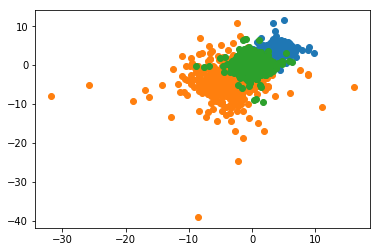

In [22]:
label_arg = true_train_label_arg


for i in range(K):
    plt.scatter(train_x[np.where((label_arg == i) & (np.abs(train_x[:,0]) < ussebba) & (np.abs(train_x[:,1]) < ussebba))[0],0],
                train_x[np.where((label_arg == i) & (np.abs(train_x[:,0]) < ussebba) & (np.abs(train_x[:,1]) < ussebba))[0],1])        
plt.show()

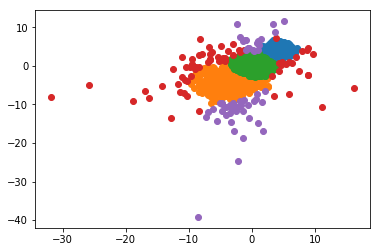

In [23]:
label_arg = label_arg_skgmm 

for i in range(K):
    plt.scatter(train_x[np.where((label_arg == i) & (np.abs(train_x[:,0]) < ussebba) & (np.abs(train_x[:,1]) < ussebba))[0],0],
                train_x[np.where((label_arg == i) & (np.abs(train_x[:,0]) < ussebba) & (np.abs(train_x[:,1]) < ussebba))[0],1])        
plt.show()

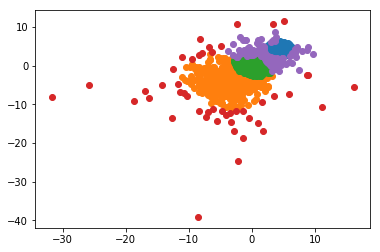

In [24]:
label_arg = label_arg_gmm

for i in range(K):
    plt.scatter(train_x[np.where((label_arg == i) & (np.abs(train_x[:,0]) < ussebba) & (np.abs(train_x[:,1]) < ussebba))[0],0],
                train_x[np.where((label_arg == i) & (np.abs(train_x[:,0]) < ussebba) & (np.abs(train_x[:,1]) < ussebba))[0],1])        
plt.show()

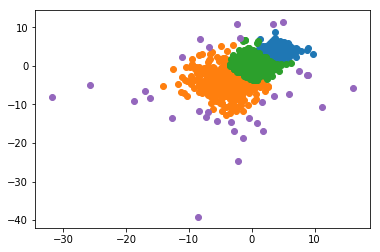

In [25]:
label_arg = label_arg_hsmm

for i in range(K):
    plt.scatter(train_x[np.where((label_arg == i) & (np.abs(train_x[:,0]) < ussebba) & (np.abs(train_x[:,1]) < ussebba))[0],0],
                train_x[np.where((label_arg == i) & (np.abs(train_x[:,0]) < ussebba) & (np.abs(train_x[:,1]) < ussebba))[0],1])        
plt.show()

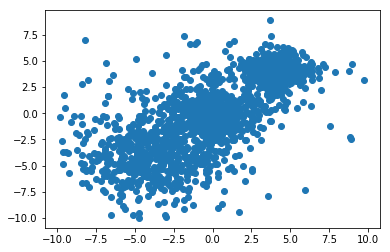

In [28]:
plt.scatter(train_x[focus_ind1,0], train_x[focus_ind1,1])

In [ ]:
printmd("### 5. Correct number of labeling of GMM:")
printmd("+ {0}/{1}".format(correct_num_skgmm, len(label_arg_hsmm)))

printmd("### 5. Correct number of labeling of GMM:")
printmd("+ {0}/{1}".format(correct_num_gmm, len(label_arg_hsmm)))

printmd("### 6. Correct number of labeling of HSMM:")
printmd("+ {0}/{1}".format(correct_num_hsmm, len(label_arg_hsmm)))

printmd("### 7. Generalization error of GMM:")
printmd("+ {0}".format(evaluate_log_loss(gmm_result, true_param, noise_data_num, test_x, true_logpdf, pred_logpdf_gmm)))

printmd("### 8. Generalization error of HSMM:")
printmd("+ {0}".format(evaluate_log_loss(hsmm_result, true_param, noise_data_num, test_x, true_logpdf, pred_logpdf_hsmm)))

printmd("### 9. Data distribution labeled by GMM:")
plot_scatter_with_label(train_x, label_arg_gmm,  K, noise_data_num)

printmd("### 10. Data distribution labeled by HSMM:")
plot_scatter_with_label(train_x, label_arg_hsmm,  K, noise_data_num)

## 1. Cluster distribution is Gaussian distribution

In [19]:
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_multivariate_normal)

In [20]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = norm.rvs(loc=true_b[true_train_label_arg[i],j], scale=1/np.sqrt(true_s[true_train_label_arg[i],j]), size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = norm.rvs(loc=true_b[true_test_label_arg[i],j], scale=1/np.sqrt(true_s[true_test_label_arg[i],j]), size = 1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

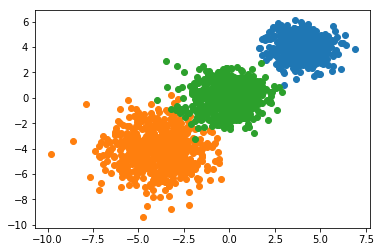

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([3.27961065e-01, 3.27541237e-01, 3.44397723e-01, 4.99875031e-05,
       4.99875031e-05]), 'est_mean': array([[ 3.99490613,  3.97492335],
       [-3.88298473, -4.08525156],
       [-0.03757595,  0.02203085],
       [ 0.0253976 , -0.02688319],
       [ 0.0253976 , -0.02688319]]), 'est_precision': array([[[ 1.48314084e+00,  5.02402972e-02],
        [ 5.02402972e-02,  1.74135280e+00]],

       [[ 4.91350674e-01, -1.14627944e-03],
        [-1.14627944e-03,  4.43830888e-01]],

       [[ 9.32070381e-01, -4.73332144e-02],
        [-4.73332144e-02,  1.00267040e+00]],

       [[ 2.00000000e+00,  1.51605100e-18],
        [ 1.51605100e-18,  2.00000000e+00]],

       [[ 2.00000000e+00,  1.51605100e-18],
        [ 1.51605100e-18,  2.00000000e+00]]])}


### 3. Learning by GMM:

4440.599399477653
4440.598942550976
4440.598942550979
4440.598942550982
4440.598942550976
mean plug-in parameters: 
 {'est_ratio': array([3.28690066e-01, 8.58990002e-04, 3.42248677e-01, 3.28152280e-01,
       4.99875031e-05]), 'est_mean': array([[-3.87611342, -4.07759515],
       [-3.20192822,  2.66126882],
       [-0.02517526,  0.02090824],
       [ 3.99401152,  3.97399137],
       [ 0.        ,  0.        ]]), 'est_precision': array([[0.48868978, 0.44228668],
       [1.31211633, 1.31831844],
       [0.95808489, 1.02005831],
       [1.4723131 , 1.72638953],
       [1.        , 1.        ]])}


### 4. Learning by HSMM:

884.2708164913256
884.2708164913383
884.2708164913281
884.2708164913431
884.2708164913381
mean plug-in parameters: 
 {'est_ratio': array([3.26374733e-01, 4.99875031e-05, 3.28051204e-01, 4.99875031e-05,
       3.45474088e-01]), 'est_mean': array([[-3.83400769e+00, -4.09095370e+00],
       [-1.15077471e-16, -7.17684748e-17],
       [ 3.99766450e+00,  3.99050240e+00],
       [-1.15077471e-16, -7.17684748e-17],
       [-2.62063661e-02,  1.61578334e-02]]), 'est_precision': array([[ 4.00996288,  3.71629168],
       [ 1.        ,  1.        ],
       [11.46085458, 13.06907976],
       [ 1.        ,  1.        ],
       [ 7.40124767,  7.69529719]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1982/2000

### 5. Correct number of labeling of GMM:

+ 1980/2000

### 6. Correct number of labeling of HSMM:

+ 1981/2000

### 7. Generalization error of GMM by sklearn:

+ -0.02023290806725483

### 8. Generalization error of GMM:

+ -0.020284715162827895

### 9. Generalization error of HSMM:

+ 0.019628213074995283

### 10. Data distribution labeled by GMM by sklearn:

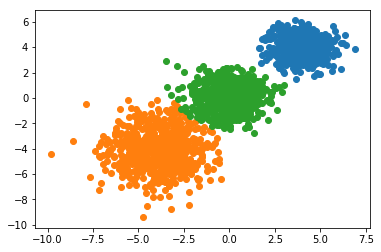

### 11. Data distribution labeled by GMM:

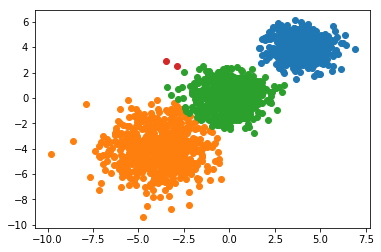

### 12. Data distribution labeled by HSMM:

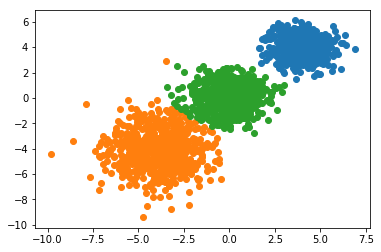

In [21]:
learning_and_labeling()

## 2. Cluster distribution is Hyperbolic secant distribution

In [26]:
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_hypsecant)

In [27]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = random_hsm(n = 1, loc=true_b[true_train_label_arg[i],j], scale=true_s[true_train_label_arg[i],j])

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = random_hsm(n = 1, loc=true_b[true_test_label_arg[i],j], scale=true_s[true_test_label_arg[i],j])

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

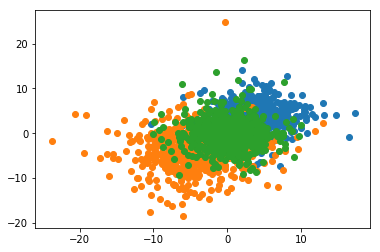

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([4.99875031e-05, 4.99875031e-05, 4.97536095e-01, 1.28153658e-01,
       3.74210272e-01]), 'est_mean': array([[-2.87532840e-03,  3.40317391e-02],
       [-2.87532840e-03,  3.40317391e-02],
       [ 2.95639989e-01,  9.84208299e-02],
       [ 4.18630399e+00,  4.36198963e+00],
       [-1.83406326e+00, -1.53337508e+00]]), 'est_precision': array([[[ 2.00000000e+00,  2.17276033e-19],
        [ 2.17276033e-19,  2.00000000e+00]],

       [[ 2.00000000e+00,  2.17276033e-19],
        [ 2.17276033e-19,  2.00000000e+00]],

       [[ 9.99530417e-02, -5.45297790e-02],
        [-5.45297790e-02,  9.86165039e-02]],

       [[ 4.12652734e-01,  3.97873751e-02],
        [ 3.97873751e-02,  4.32445529e-01]],

       [[ 3.35209567e-02, -1.10317739e-02],
        [-1.10317739e-02,  3.80494812e-02]]])}


### 3. Learning by GMM:

7934.703316850785
7951.3627111769
7934.703316845516
7951.358662918093
7934.703316856794
mean plug-in parameters: 
 {'est_ratio': array([0.20777418, 0.00054986, 0.17179238, 0.29263789, 0.32724568]), 'est_mean': array([[ 3.81285803,  3.51771605],
       [-0.32087089, 24.9057342 ],
       [ 3.9308989 ,  4.06884021],
       [-0.35591159, -0.51621256],
       [-4.17397022, -3.84146287]]), 'est_precision': array([[0.0718311 , 0.07846871],
       [1.24996751, 1.08203632],
       [0.37399122, 0.35427374],
       [0.14824458, 0.1465054 ],
       [0.04951194, 0.05479655]])}


### 4. Learning by HSMM:

4206.942339660998
4193.482241584531
4193.509747416119
4213.246819143914
4206.898777038879
mean plug-in parameters: 
 {'est_ratio': array([4.22890231e-01, 3.24071881e-01, 4.99875031e-05, 2.52937912e-01,
       4.99875031e-05]), 'est_mean': array([[-1.76838477e-01, -4.05409686e-01],
       [ 4.00257903e+00,  4.08483323e+00],
       [-2.38313734e-16,  4.82221101e-16],
       [-4.83149341e+00, -4.41219067e+00],
       [-2.38313734e-16,  4.82221101e-16]]), 'est_precision': array([[0.79879578, 0.89282426],
       [1.42278561, 1.55116553],
       [1.        , 1.        ],
       [0.55940658, 0.52943084],
       [1.        , 1.        ]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1240/2000

### 5. Correct number of labeling of GMM:

+ 1382/2000

### 6. Correct number of labeling of HSMM:

+ 1562/2000

### 7. Generalization error of GMM by sklearn:

+ -0.07248436704359014

### 8. Generalization error of GMM:

+ -0.06646271477498483

### 9. Generalization error of HSMM:

+ -0.08321906950653561

### 10. Data distribution labeled by GMM by sklearn:

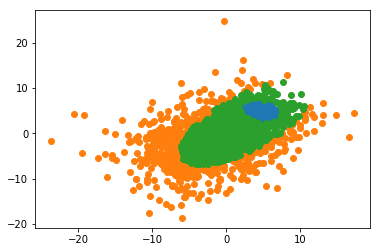

### 11. Data distribution labeled by GMM:

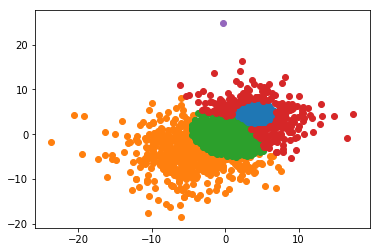

### 12. Data distribution labeled by HSMM:

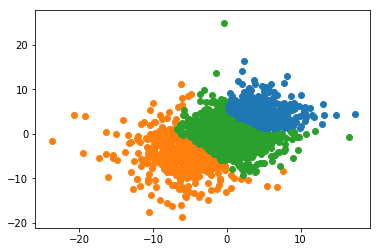

In [28]:
learning_and_labeling()

## 3. Cluster distribution is Laplace distribution

In [29]:
logpdf_laplace = lambda x, mean, precision: laplace.logpdf(test_x, loc=mean, scale=1/np.diag(precision)).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_laplace)

In [30]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = laplace.rvs(loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = laplace.rvs(loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

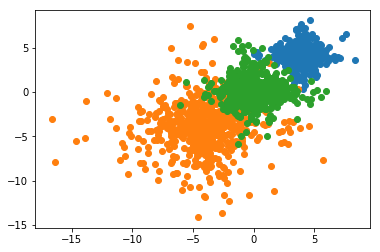

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([0.05233909, 0.28138747, 0.20162259, 0.40380005, 0.0608508 ]), 'est_mean': array([[-3.76404119, -6.34433646],
       [ 3.98047022,  4.06557522],
       [-0.03036602,  0.04506686],
       [-1.7017396 , -1.17479071],
       [-4.35726219, -4.01497301]]), 'est_precision': array([[[ 0.93070333,  0.06859566],
        [ 0.06859566,  0.13889793]],

       [[ 2.1456326 , -0.01925136],
        [-0.01925136,  1.86798664]],

       [[ 1.86556929,  0.14572101],
        [ 0.14572101,  1.45128777]],

       [[ 0.09919331, -0.06229579],
        [-0.06229579,  0.12465357]],

       [[ 0.71722706,  0.31145524],
        [ 0.31145524,  2.16690452]]])}


### 3. Learning by GMM:

5523.8644931096105
5561.058659868755
5543.020798480525
5561.058659868757
5523.86449308451
mean plug-in parameters: 
 {'est_ratio': array([0.15733977, 0.19233999, 0.25063209, 0.11191904, 0.2877691 ]), 'est_mean': array([[-3.97993928, -3.84312714],
       [-3.83694952, -3.54891677],
       [ 3.99692812,  4.05246377],
       [ 3.10596143,  3.30940895],
       [-0.07054652,  0.0136051 ]]), 'est_precision': array([[0.50402706, 0.36123339],
       [0.08243311, 0.08206518],
       [2.55391918, 2.34313556],
       [0.27944828, 0.24588962],
       [0.96844905, 0.94556411]])}


### 4. Learning by HSMM:

1781.6891874137248
1781.689187413734
1781.689187413714
1781.689187413718
1781.6891874137439
mean plug-in parameters: 
 {'est_ratio': array([4.99875031e-05, 4.99875031e-05, 3.28433003e-01, 3.50820549e-01,
       3.20646473e-01]), 'est_mean': array([[-4.27153700e-16, -3.05866117e-16],
       [-4.27153700e-16, -3.05866117e-16],
       [ 3.96515634e+00,  4.03063975e+00],
       [-3.06525510e-02,  7.98902396e-02],
       [-4.09248537e+00, -3.92535532e+00]]), 'est_precision': array([[ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [12.14852944, 10.73795094],
       [ 5.37464419,  5.33165198],
       [ 1.54104654,  1.38627123]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1438/2000

### 5. Correct number of labeling of GMM:

+ 1498/2000

### 6. Correct number of labeling of HSMM:

+ 1921/2000

### 7. Generalization error of GMM by sklearn:

+ -0.3682429520245036

### 8. Generalization error of GMM:

+ -0.3705443727300545

### 9. Generalization error of HSMM:

+ -0.40235802101412255

### 10. Data distribution labeled by GMM by sklearn:

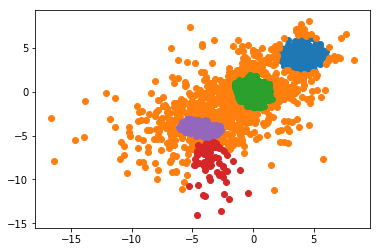

### 11. Data distribution labeled by GMM:

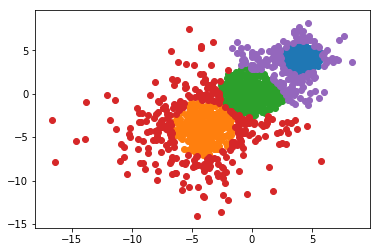

### 12. Data distribution labeled by HSMM:

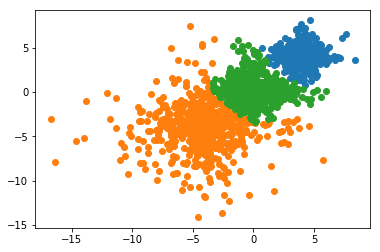

In [31]:
learning_and_labeling()

## 4. Cluster distribution is Gumbel distribution

In [32]:
logpdf_gumbel = lambda x, mean, precision: gumbel_r.logpdf(test_x, loc=mean, scale=1/np.diag(precision)).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_gumbel)

In [33]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = gumbel_r.rvs(loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = gumbel_r.rvs(loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

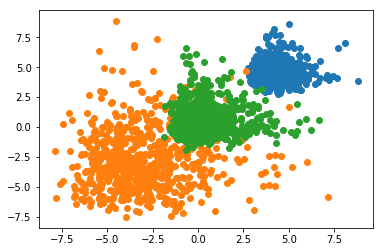

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([0.26534371, 0.25798559, 0.25575292, 0.07031727, 0.15060051]), 'est_mean': array([[-3.58110686, -3.35739128],
       [ 4.14549558,  4.19675282],
       [ 0.1971785 ,  0.33125028],
       [ 4.97278793,  5.30427334],
       [ 0.8853515 ,  0.91205132]]), 'est_precision': array([[[ 0.32523006,  0.0362606 ],
        [ 0.0362606 ,  0.26759385]],

       [[ 2.68946758,  0.24955568],
        [ 0.24955568,  2.65405288]],

       [[ 1.31650756, -0.01113448],
        [-0.01113448,  1.01237704]],

       [[ 1.01110198,  0.34543805],
        [ 0.34543805,  0.89574165]],

       [[ 0.21272392,  0.08289724],
        [ 0.08289724,  0.2054686 ]]])}


### 3. Learning by GMM:

5152.479879453285
5172.783375332232
5172.783379045174
5172.7833755109
5174.980854070322
mean plug-in parameters: 
 {'est_ratio': array([0.22701177, 0.1781317 , 0.23958501, 0.084486  , 0.27078553]), 'est_mean': array([[-3.69939593, -3.60729446],
       [ 0.13889699,  0.36237692],
       [ 4.1633581 ,  4.18173126],
       [ 4.70718925,  5.128972  ],
       [ 0.26785667,  0.39140878]]), 'est_precision': array([[0.35917847, 0.31983036],
       [0.11553733, 0.13036748],
       [2.62138365, 2.77706305],
       [0.95138768, 0.77287761],
       [1.15833623, 0.95387389]])}


### 4. Learning by HSMM:

1550.275814000114
1543.5329095022748
1529.782669374923
1529.7826693750465
1529.782669375022
mean plug-in parameters: 
 {'est_ratio': array([0.11690872, 0.00838079, 0.33764384, 0.39794764, 0.13911901]), 'est_mean': array([[-4.53131668, -2.21781689],
       [ 4.15503918, -2.97401958],
       [ 4.22169576,  4.30003591],
       [ 0.21899951,  0.35305182],
       [-3.03276641, -4.36576497]]), 'est_precision': array([[ 4.84923921,  1.49371812],
       [ 2.21919861,  1.40157829],
       [12.32125118, 10.52344545],
       [ 4.94424793,  4.39183664],
       [ 2.49944426,  4.07060203]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1626/2000

### 5. Correct number of labeling of GMM:

+ 1602/2000

### 6. Correct number of labeling of HSMM:

+ 1653/2000

### 7. Generalization error of GMM by sklearn:

+ -2.5264764253153205

### 8. Generalization error of GMM:

+ -2.527544816276661

### 9. Generalization error of HSMM:

+ -2.516878467848934

### 10. Data distribution labeled by GMM by sklearn:

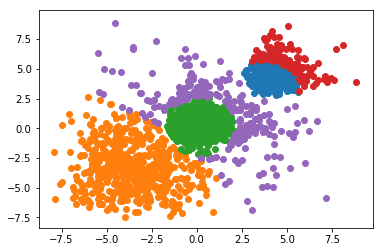

### 11. Data distribution labeled by GMM:

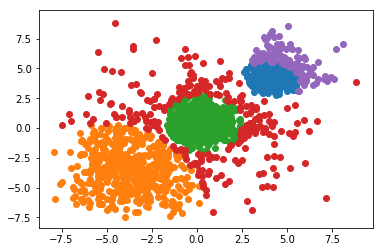

### 12. Data distribution labeled by HSMM:

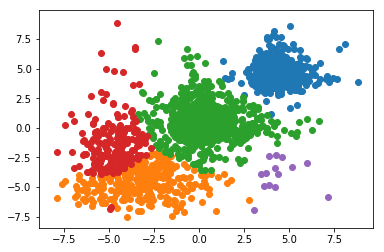

In [34]:
learning_and_labeling()

## 5. Cluster distribution is student distribution

In [35]:
logpdf_t = lambda x, mean, precision: t.logpdf(test_x, df=1.5, loc=mean, scale=1/np.diag(precision)).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_t)

In [36]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = t.rvs(df = 2, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = t.rvs(df = 1.5, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

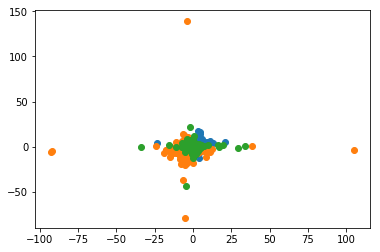

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([6.37918776e-02, 2.38510304e-01, 6.96598094e-01, 5.49862534e-04,
       5.49862534e-04]), 'est_mean': array([[ -3.76944719,  -3.86329765],
       [  4.02210107,   4.06544611],
       [ -1.06526231,  -1.11019781],
       [105.12029556,  -3.40919765],
       [ -3.57279041, 139.39732802]]), 'est_precision': array([[[ 4.44299228e-03, -5.75472015e-04],
        [-5.75472015e-04,  7.65225352e-03]],

       [[ 1.88376499e+00,  2.49929857e-01],
        [ 2.49929857e-01,  2.06415778e+00]],

       [[ 1.35447180e-01, -8.09592427e-02],
        [-8.09592427e-02,  1.41956971e-01]],

       [[ 3.84884823e-01,  6.89751340e-02],
        [ 6.89751340e-02,  2.49774943e+00]],

       [[ 2.49848702e+00,  5.85218977e-02],
        [ 5.85218977e-02,  2.34514004e-01]]])}


### 3. Learning by GMM:

6592.666141651109
6606.993021957807
6647.515153466937
6647.515153466934
6647.515153466934
mean plug-in parameters: 
 {'est_ratio': array([0.22148463, 0.25896267, 0.0080632 , 0.28158133, 0.22990816]), 'est_mean': array([[-1.07996231, -1.42131119],
       [ 0.0311296 ,  0.1070933 ],
       [-2.99322148, -1.06370499],
       [ 3.99079846,  4.01181472],
       [-3.65800236, -3.54999418]]), 'est_precision': array([[3.09526435e-02, 2.93148156e-02],
       [6.92563915e-01, 8.47036002e-01],
       [5.85254670e-04, 6.79139232e-04],
       [1.42498880e+00, 1.43786754e+00],
       [1.92239130e-01, 2.32104934e-01]])}


### 4. Learning by HSMM:

2827.127723962426
2827.1277239791802
2827.127723980212
2815.5317882141153
2827.127723980396
mean plug-in parameters: 
 {'est_ratio': array([0.31048485, 0.01890455, 0.02816139, 0.32707261, 0.31537661]), 'est_mean': array([[-0.02551298,  0.04412941],
       [ 3.15841956,  0.63807722],
       [-3.78781114, -3.01777847],
       [-3.63145636, -3.73600477],
       [ 4.01350529,  4.01948175]]), 'est_precision': array([[4.04289999, 4.96978727],
       [0.01781555, 0.57555403],
       [0.98114704, 0.03360585],
       [0.82347117, 1.09580854],
       [8.56930048, 8.19184484]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1276/2000

### 5. Correct number of labeling of GMM:

+ 1557/2000

### 6. Correct number of labeling of HSMM:

+ 1782/2000

### 7. Generalization error of GMM by sklearn:

+ 2.3117576522319236

### 8. Generalization error of GMM:

+ 0.15169411025949722

### 9. Generalization error of HSMM:

+ -0.09380373995749865

### 10. Data distribution labeled by GMM by sklearn:

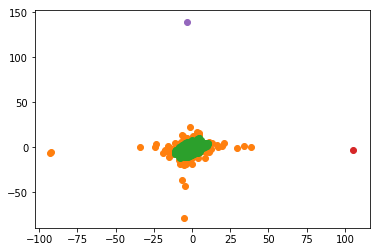

### 11. Data distribution labeled by GMM:

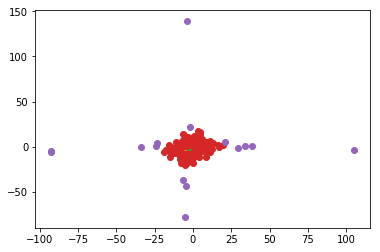

### 12. Data distribution labeled by HSMM:

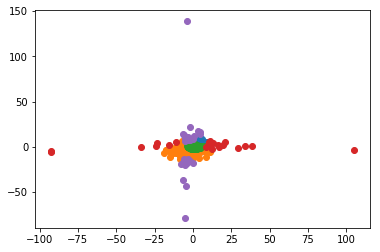

In [37]:
learning_and_labeling()

## 6. Cluster distribution is Cauchy distribution

In [38]:
logpdf_cauchy = lambda x, mean, precision: cauchy.logpdf(test_x, loc=mean, scale=1/np.diag(precision)).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_cauchy)

In [39]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = cauchy.rvs(loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = cauchy.rvs(loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

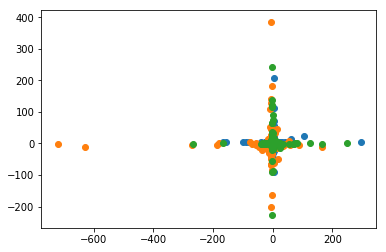

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([0.34862006, 0.00104974, 0.06119905, 0.05838744, 0.53074372]), 'est_mean': array([[   2.27039009,    2.31239148],
       [-672.75717684,   -7.71053843],
       [  -0.82506359,   10.92929624],
       [  -3.15555199,   -1.25608846],
       [  -1.33786109,   -1.0218677 ]]), 'est_precision': array([[[ 7.25104982e-01, -6.35714289e-01],
        [-6.35714289e-01,  7.45542084e-01]],

       [[ 8.37043161e-03,  7.19773494e-02],
        [ 7.19773494e-02,  7.30869161e-01]],

       [[ 4.74435060e-02, -4.89861455e-05],
        [-4.89861455e-05,  1.98153883e-04]],

       [[ 1.84326235e-04, -1.82514305e-04],
        [-1.82514305e-04,  2.74882081e-02]],

       [[ 5.65892692e-02, -2.20528134e-02],
        [-2.20528134e-02,  5.22936918e-02]]])}


### 3. Learning by GMM:

8811.726910282101
8733.451380652263
8733.451380652263
8644.065032025785
8733.451380652266
mean plug-in parameters: 
 {'est_ratio': array([0.52705402, 0.2143623 , 0.0517531 , 0.05790076, 0.14892982]), 'est_mean': array([[ -1.49840544,  -1.17580959],
       [  4.00370077,   4.00703368],
       [-16.39571481,  -1.63610619],
       [ -0.66738588,  11.80190751],
       [ -0.05453447,   0.09267349]]), 'est_precision': array([[4.34370013e-02, 4.13263762e-02],
       [1.51173743e+00, 1.32233438e+00],
       [6.97319851e-05, 2.53060459e-02],
       [4.47222563e-02, 1.88594233e-04],
       [1.34868031e+00, 1.15517387e+00]])}


### 4. Learning by HSMM:

4925.107278920848
4786.173623367571
4786.173623367533
4786.173623367558
4786.173623367544
mean plug-in parameters: 
 {'est_ratio': array([0.05819201, 0.2767366 , 0.06908064, 0.19871628, 0.39727447]), 'est_mean': array([[-6.43225398e-01, -6.89829751e-01],
       [ 3.98211214e+00,  4.02536881e+00],
       [-3.55668107e-01,  7.13428332e+00],
       [ 2.46027552e-03,  1.32152074e-01],
       [-3.07892297e+00, -2.71997954e+00]]), 'est_precision': array([[1.73692213e-03, 2.96904664e-01],
       [6.67420745e+00, 5.69052551e+00],
       [4.01755845e-01, 3.54557705e-03],
       [6.61465253e+00, 4.87235832e+00],
       [5.05149939e-01, 4.90709576e-01]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1019/2000

### 5. Correct number of labeling of GMM:

+ 1309/2000

### 6. Correct number of labeling of HSMM:

+ 1477/2000

### 7. Generalization error of GMM by sklearn:

+ 3.7948608166855906

### 8. Generalization error of GMM:

+ 1.7963747415083828

### 9. Generalization error of HSMM:

+ 0.09230829532459167

### 10. Data distribution labeled by GMM by sklearn:

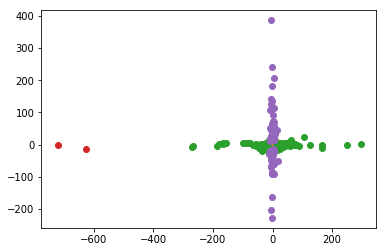

### 11. Data distribution labeled by GMM:

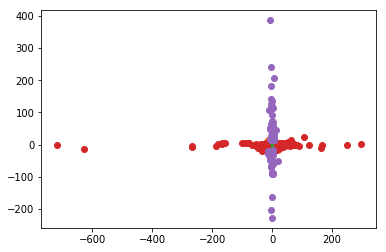

### 12. Data distribution labeled by HSMM:

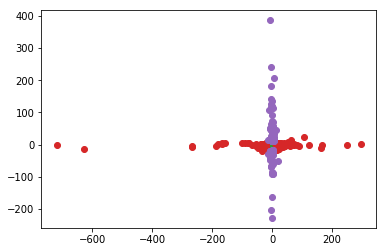

In [40]:
learning_and_labeling()

## 7. Cluster distribution is Gamma distribution
+ Remark: Actually support of gamma distribution is not whole real line, but scipy can generate data with loc on real value.

In [41]:
logpdf_gamma = lambda x, mean, precision: gamma.logpdf(test_x, a=1, loc=mean, scale=1/np.diag(precision)).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_gamma)

In [42]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = gamma.rvs(a = 1, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = gamma.rvs(a = 1, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

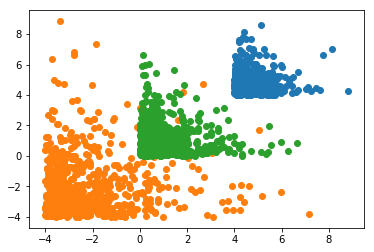

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([0.12733216, 0.28856788, 0.24411629, 0.24016802, 0.09981566]), 'est_mean': array([[-2.3083558 , -3.20557915],
       [ 4.517274  ,  4.57771848],
       [ 0.619734  ,  0.7580205 ],
       [ 1.46787831,  1.49393421],
       [-3.4065856 , -1.78905225]]), 'est_precision': array([[[ 0.94615028, -0.20491481],
        [-0.20491481,  2.97535359]],

       [[ 5.36390439,  0.12486286],
        [ 0.12486286,  4.26583684]],

       [[ 4.31345196,  0.16609124],
        [ 0.16609124,  2.83735243]],

       [[ 0.16153214, -0.05828708],
        [-0.05828708,  0.1468877 ]],

       [[ 6.15562278, -0.32812456],
        [-0.32812456,  0.54899306]]])}


### 3. Learning by GMM:

3787.829759694037
3787.8297596940197
3848.095213853409
3830.5038980223853
3787.829759694114
mean plug-in parameters: 
 {'est_ratio': array([0.22903276, 0.20866636, 0.11197109, 0.23684346, 0.21348633]), 'est_mean': array([[ 0.50415927,  0.63677033],
       [-2.80674925, -2.76638884],
       [ 4.97454101,  5.19836739],
       [ 0.61798782,  0.76077305],
       [ 4.40578165,  4.43845447]]), 'est_precision': array([[0.17233099, 0.1895312 ],
       [1.26234046, 1.10786437],
       [1.69663446, 1.19382779],
       [4.34174216, 2.84550196],
       [9.78047326, 8.57166932]])}


### 4. Learning by HSMM:

313.7820394830901
345.0587259000804
313.78203947620204
313.78203949207636
313.7820394865639
mean plug-in parameters: 
 {'est_ratio': array([0.07979082, 0.10322507, 0.32756911, 0.31661762, 0.17279738]), 'est_mean': array([[ 2.38708941,  0.82936606],
       [-3.15899121, -0.99385668],
       [ 4.48893725,  4.54900602],
       [ 0.57455072,  0.76446438],
       [-2.54468354, -3.1519613 ]]), 'est_precision': array([[ 2.20793479,  1.94500433],
       [11.58376578,  2.17822554],
       [25.03310068, 19.85344841],
       [18.93326531,  9.31765126],
       [ 5.29812199, 12.97859299]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1393/2000

### 5. Correct number of labeling of GMM:

+ 1401/2000

### 6. Correct number of labeling of HSMM:

+ 1650/2000

### 7. Generalization error of GMM by sklearn:

+ -0.11633792272288769

### 8. Generalization error of GMM:

+ -0.13593598257029477

### 9. Generalization error of HSMM:

+ -0.10291352823167303

### 10. Data distribution labeled by GMM by sklearn:

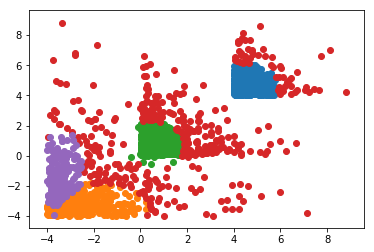

### 11. Data distribution labeled by GMM:

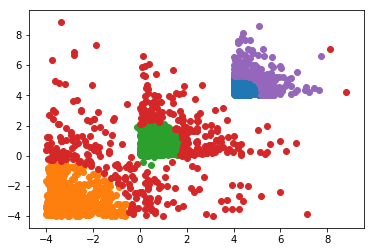

### 12. Data distribution labeled by HSMM:

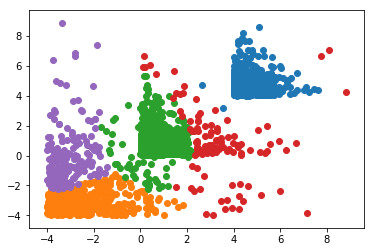

In [43]:
learning_and_labeling()

## 8. Cluster distribution is Skew Normal distribution

In [44]:
logpdf_skewnormal = lambda x, mean, precision: skewnorm.logpdf(test_x, a=2, loc=mean, scale=1/np.diag(precision)).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_skewnormal)

In [45]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = skewnorm.rvs(a = 2, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = skewnorm.rvs(a = 2, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

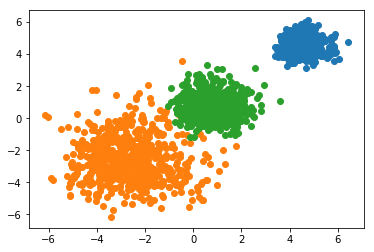

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([0.15616778, 0.32847998, 0.12328044, 0.19273975, 0.19933206]), 'est_mean': array([[ 0.53036779,  0.41286043],
       [ 4.4912682 ,  4.49940232],
       [-2.2310672 , -3.52553518],
       [-2.98941372, -2.00701496],
       [ 0.8559455 ,  0.87483415]]), 'est_precision': array([[[ 3.91468737, -0.45333779],
        [-0.45333779,  3.34877676]],

       [[ 4.52175174, -0.19334341],
        [-0.19334341,  4.3948944 ]],

       [[ 0.50386308,  0.05216014],
        [ 0.05216014,  1.52661861]],

       [[ 0.82077926, -0.12992542],
        [-0.12992542,  0.54206278]],

       [[ 1.51486284,  0.15822723],
        [ 0.15822723,  1.44565528]]])}


### 3. Learning by GMM:

3220.0170116761774
3220.0161905092427
3212.3160662792343
3207.8981591473257
3212.3058526456703
mean plug-in parameters: 
 {'est_ratio': array([0.02270847, 0.33519793, 0.18523618, 0.1283947 , 0.32846273]), 'est_mean': array([[ 0.90503674,  1.85278811],
       [ 0.68731943,  0.58995572],
       [-2.91225833, -1.98201453],
       [-2.40827656, -3.54512276],
       [ 4.49134123,  4.49946193]]), 'est_precision': array([[0.93645726, 1.44374183],
       [2.02007702, 2.10996183],
       [0.81693973, 0.55647397],
       [0.45469439, 1.49043611],
       [4.45453997, 4.33018153]])}


### 4. Learning by HSMM:

-274.0286779781759
-274.02867797814133
-274.02867797813633
-274.0286779781377
-274.0286779780945
mean plug-in parameters: 
 {'est_ratio': array([3.08328147e-01, 3.62818896e-01, 4.99875031e-05, 3.28752982e-01,
       4.99875031e-05]), 'est_mean': array([[-2.77400115e+00, -2.75769969e+00],
       [ 6.56892425e-01,  6.22254173e-01],
       [-5.81231159e-17, -4.07278051e-17],
       [ 4.46355199e+00,  4.47940879e+00],
       [-5.81231159e-17, -4.07278051e-17]]), 'est_precision': array([[ 4.81458889,  4.36678992],
       [13.94659733, 13.16389743],
       [ 1.        ,  1.        ],
       [30.02846943, 28.60684406],
       [ 1.        ,  1.        ]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1406/2000

### 5. Correct number of labeling of GMM:

+ 1679/2000

### 6. Correct number of labeling of HSMM:

+ 1974/2000

### 7. Generalization error of GMM by sklearn:

+ -1.602628382789609

### 8. Generalization error of GMM:

+ -1.602178591030022

### 9. Generalization error of HSMM:

+ -1.5571163127515375

### 10. Data distribution labeled by GMM by sklearn:

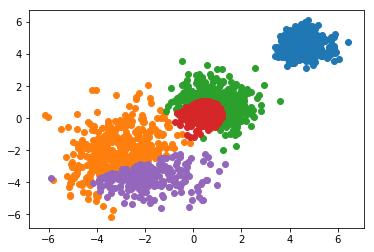

### 11. Data distribution labeled by GMM:

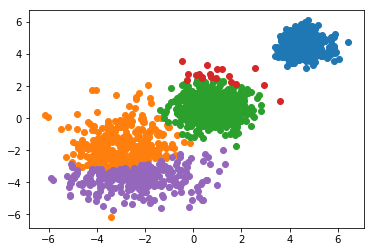

### 12. Data distribution labeled by HSMM:

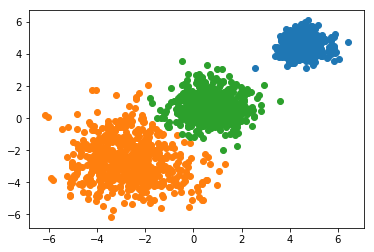

In [46]:
learning_and_labeling()

## 9. Cluster distribution is Parato distribution
+ Parato distribution has inifite variance if $shape \leq 2$.

In [47]:
logpdf_pareto = lambda x, mean, precision: pareto.logpdf(test_x, b=1.5, loc=mean, scale=1/np.diag(precision)).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_pareto)

In [48]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = pareto.rvs(b = 1.5, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = pareto.rvs(b = 1.5, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

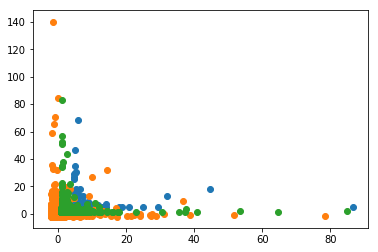

### 2. Learning by sklearn.mixture.BayesianGaussianMixture:

mean plug-in parameters 
 {'est_ratio': array([0.44325161, 0.27769354, 0.03114214, 0.02786374, 0.22004897]), 'est_mean': array([[ 0.50582994,  0.55916449],
       [ 3.77575974,  4.32555062],
       [ 2.29048551, 28.79518056],
       [25.7167752 ,  2.07967188],
       [ 5.04785733,  5.06932666]]), 'est_precision': array([[[ 9.10732876e-01, -6.40932077e-01],
        [-6.40932077e-01,  8.60244432e-01]],

       [[ 9.35070268e-02, -4.09934588e-03],
        [-4.09934588e-03,  8.17934412e-02]],

       [[ 1.06944476e-01,  2.85961744e-03],
        [ 2.85961744e-03,  1.92526352e-03]],

       [[ 2.97162334e-03, -1.03637003e-03],
        [-1.03637003e-03,  7.88787934e-02]],

       [[ 8.46299481e+00,  8.46197368e-02],
        [ 8.46197368e-02,  7.65485736e+00]]])}


### 3. Learning by GMM:

5277.432636184343
5699.196768286507
5541.058940584245
5699.196768286456
5541.0589405842875
mean plug-in parameters: 
 {'est_ratio': array([0.22092635, 0.33745926, 0.17740287, 0.217369  , 0.04684253]), 'est_mean': array([[ 5.05057861,  5.07158833],
       [ 3.53665963,  4.02900991],
       [-1.03137097, -1.08667622],
       [ 1.46683623,  1.62456702],
       [15.48982374, 18.74726772]]), 'est_precision': array([[7.98128394e+00, 7.28116454e+00],
       [9.23782108e-02, 7.86302391e-02],
       [1.50612426e+00, 1.74828871e+00],
       [5.59220587e+00, 2.71765563e+00],
       [2.85428561e-03, 1.82075976e-03]])}


### 4. Learning by HSMM:

2145.011238767537
2145.0112387675263
1744.7424957455435
2145.011238767616
2145.0112387674462
mean plug-in parameters: 
 {'est_ratio': array([0.30494188, 0.18921496, 0.2724362 , 0.18511358, 0.04829338]), 'est_mean': array([[ 1.49253318,  1.57554199],
       [ 5.12265513,  3.72442308],
       [ 5.04031445,  5.08999536],
       [-1.1838095 , -1.1870111 ],
       [ 1.89715196, 16.30309548]]), 'est_precision': array([[12.75553979, 10.55285848],
       [ 0.16691206,  0.62242507],
       [29.26027235, 21.7244415 ],
       [10.48261976, 10.36003039],
       [ 1.027664  ,  0.03180667]])}


### 5. Correct number of labeling of GMM by sklearn:

+ 1137/2000

### 5. Correct number of labeling of GMM:

+ 1261/2000

### 6. Correct number of labeling of HSMM:

+ 1476/2000

### 7. Generalization error of GMM by sklearn:

+ -1.3277336862731068

### 8. Generalization error of GMM:

+ -1.4547462889426142

### 9. Generalization error of HSMM:

+ -1.7854519561642228

### 10. Data distribution labeled by GMM by sklearn:

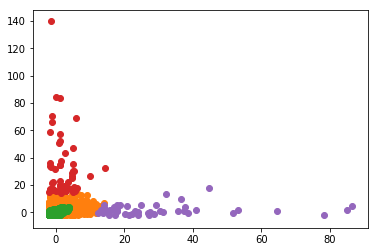

### 11. Data distribution labeled by GMM:

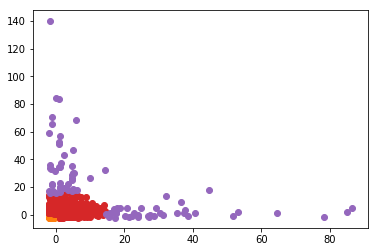

### 12. Data distribution labeled by HSMM:

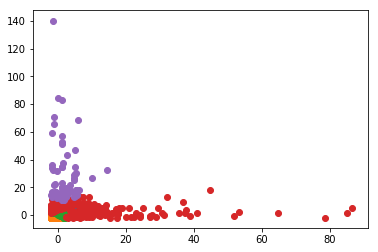

In [49]:
learning_and_labeling()